In [1]:
import os,sys,glob
import re
import numpy as np

### Custom code
helpers = os.path.abspath('../../../Helpers')
if helpers not in sys.path:
    sys.path.append(helpers)
from utils import (
    mkdir_p,
)

from gammapy.data import EventList
from gammapy.datasets import Datasets, MapDataset
from gammapy.irf import EDispKernelMap, EDispKernel, EDispMap, PSFMap
from gammapy.maps import Map, MapAxis, WcsGeom
from gammapy.modeling import Fit

from astropy.coordinates import SkyCoord
from astropy.io import fits as pyfits
from astropy import units as u

from gammapy.modeling.models import (
    Models,
    SkyModel,
    PointSpatialModel,
    PowerLawNormSpectralModel,
    PowerLawSpectralModel,
    TemplateSpatialModel,
    create_fermi_isotropic_diffuse_model,
    GaussianPrior
)
from gammapy.data import GTI
from gammapy.catalog import SourceCatalog4FGL

## Load files and generate the corresponding gammapy objects

In [2]:
basedir = os.path.abspath("../../../")
outdir  = f"{basedir}/LAT/MJD60373/"

# Paths
fermidir = "/mnt/sdb1/OP313_Paper_Gammapy/Fermi/NuSTAR1/"
evtfile  = f"{fermidir}/OP313_LAT_Analysis_LC_154_FRONTBACK_MkTime.fits"           # gtktime
psffile  = f"{fermidir}/OP313_LAT_Analysis_LC_154_FRONTBACK_PowerLaw_psf.fits"     # gtpsf
expfile  = f"{fermidir}/OP313_LAT_Analysis_LC_154_FRONTBACK_BinnedMap.fits"        # gtexpcube2
drmfile  = f"{fermidir}/OP313_LAT_Analysis_LC_154_FRONTBACK_PowerLaw_eDRM.fits"    # gtdrm

# Load files into gammapy needed to build the dataset
events   = EventList.read(evtfile)
exposure = Map.read(expfile)
psfmap   = PSFMap.read(psffile, format="gtpsf")
drmmap   = pyfits.open(drmfile)
gtis     = GTI.read(evtfile)

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set MJD-OBS to 60372.500000 from DATE-OBS.
Set MJD-END to 60373.500000 from DATE-END'. [astropy.wcs.wcs]


## Parse the event file to extract the center of the ROI
(we will assume that is the position of the source)

In [3]:
# Extract the sky coordinates of our source from the center of the events file
pattern = r'CIRCLE\(([^,]+),([^,]+),([^\)]+)\)'
hdu_roi_string = pyfits.open(evtfile)[1].header['DSVAL2']
match = re.search(pattern, hdu_roi_string)
# Extract the values if a match is found
ra = float(match.group(1))  # Right Ascension
dec = float(match.group(2)) # Declination
radius = float(match.group(3)) # Radius
skycenter = SkyCoord(ra=ra,dec=dec,unit='deg')

## Counts map

In [4]:
# Get the Energy axes from the DRM file
energy_lo        = drmmap["DRM"].data["ENERG_LO"] * u.MeV
energy_hi        = drmmap["DRM"].data["ENERG_HI"] * u.MeV
energy_axis      = MapAxis.from_energy_edges(np.append(energy_lo[0], energy_hi))
energy_axis_true = energy_axis.copy(name="energy_true")

counts_map = Map.create(
    skydir=skycenter,
    npix=(exposure.geom.npix[0][0], exposure.geom.npix[1][0]),
    proj="TAN",
    frame="fk5",
    binsz=(exposure.geom.pixel_scales)[0],
    axes=[energy_axis],
    dtype=float,
)
counts_map.fill_by_coord(
    {"skycoord": events.radec, "energy": events.energy}
)

## Energy dispersion matrix and edisp kernel

In [5]:
drm = drmmap["DRM"].data["MATRIX"]
drm_matrix = np.array(list(drm))

edisp_kernel = EDispKernel(
    axes=[energy_axis_true, energy_axis], data=drm_matrix
)

## Exposure

In [6]:
exposure_interp = exposure.interp_to_geom(
    counts_map.geom.as_energy_true
)

## Get auxiliary files if they do not exist 
(catalog to generate our sky models, iso and galactic diffuse files)

In [7]:
# get remote files (4FGL catalog, diffuse IEM, iso model) from Fermi datacenter
fermi_data_ssc = "https://fermi.gsfc.nasa.gov/ssc/data"
mkdir_p(f"{basedir}/LAT/AuxFiles")
!wget -nc -P {basedir}/LAT/AuxFiles {fermi_data_ssc}/access/lat/14yr_catalog/gll_psc_v35.fit
!wget -nc -P {basedir}/LAT/AuxFiles {fermi_data_ssc}/analysis/software/aux/4fgl/gll_iem_v07.fits
!wget -nc -P {basedir}/LAT/AuxFiles {fermi_data_ssc}/analysis/software/aux/iso_P8R3_SOURCE_V3_v1.txt

File ‘/home/mnievas/Projects/gammapy_mwl_workflow/LAT/AuxFiles/gll_psc_v35.fit’ already there; not retrieving.

File ‘/home/mnievas/Projects/gammapy_mwl_workflow/LAT/AuxFiles/gll_iem_v07.fits’ already there; not retrieving.

File ‘/home/mnievas/Projects/gammapy_mwl_workflow/LAT/AuxFiles/iso_P8R3_SOURCE_V3_v1.txt’ already there; not retrieving.



## Build the list of sky models:

- Target source (point like, spatial parameters frozen, spectral parameters free)
- Other sources (everything frozen)
- Diffuse galactic (frozen)
- Diffuse isotropic (norm free)

### 4FGL sources near the target

In [8]:
catalog_4fgl = SourceCatalog4FGL(filename=f"{basedir}/LAT/AuxFiles/gll_psc_v35.fit")
iscontained  = catalog_4fgl.positions.contained_by(counts_map.geom.wcs)
separations  = catalog_4fgl.positions.separation(skycenter).deg
significance = catalog_4fgl.table['Signif_Avg']
max_separation = (exposure.geom.width[0][0]/2.).to('deg').value
catalog_4fgl.table = catalog_4fgl.table[iscontained*(significance>=10)]
cat_sources  = catalog_4fgl.to_models()
separations  = catalog_4fgl.positions.separation(skycenter).deg
significance = catalog_4fgl.table['Signif_Avg']

# the min and max are not set, but if one wants to leave them free they should be set to some reasonable values.
for k,p in enumerate(cat_sources.parameters):
    #if p.interp == 'log'
    if p.name in ['norm', 'amplitude']:
        p.min = p.value/1e3
        p.max = p.value*1e3
    elif p.name in ['alpha','index','index_1','index_2']:
        p.min = 0
        p.max = 6
    elif p.name in ['beta']:
        p.min = 0
        p.max = 3
    elif p.name in ['lambda_']:
        p.min = 1e-3
        p.max = 1e3
    elif p.name in ['reference','lon_0','lat_0']:
        p.min = p.value
        p.max = p.value
        p.frozen = True

# freeze parameters from cat_sources
for k,s in enumerate(cat_sources):
    if separations[k]<10 and significance[k]>30:
        free_pars = ['norm','amplitude','alpha','index','index_1','index_2','beta','lambda_']
    elif separations[k]<5:
        free_pars = ['norm','amplitude']
    else:
        free_pars = []
    for j,p in enumerate(cat_sources[k].parameters):
        if p.name not in free_pars:
            p.frozen = True
    
    #other_sources.parameters[k].frozen = True

### Diffuse galactic/iso 

In [9]:
# Diffuse galactic: make a cutout to the ROI to speed up the fit
diff_gal = Map.read(f"{basedir}/LAT/AuxFiles/gll_iem_v07.fits")
diffuse_cutout = diff_gal.cutout(
    counts_map.geom.center_skydir, counts_map.geom.width[0]
)
template_diffuse = TemplateSpatialModel(
    diffuse_cutout, normalize=False
)
diff_gal = SkyModel(
    spectral_model=PowerLawNormSpectralModel(),
    spatial_model=template_diffuse,
    name="diffuse-iem",
)
diff_gal.parameters['norm'].min = 0.1
diff_gal.parameters['norm'].max = 10
#diff_gal.parameters['norm'].error = 0.01
diff_gal.parameters['norm'].prior = GaussianPrior(mu=1, sigma=0.2)

# Diffuse ISO model
diff_iso = create_fermi_isotropic_diffuse_model(
    filename=f"{basedir}/LAT/AuxFiles/iso_P8R3_SOURCE_V3_v1.txt", interp_kwargs={"fill_value": None}
)
diff_iso.parameters['norm'].min = 0.1
diff_iso.parameters['norm'].max = 10
#diff_iso.parameters['norm'].error = 0.01
diff_iso.parameters['norm'].prior = GaussianPrior(mu=1, sigma=0.2)


### Target source and full skymodel

In [10]:
# Target source model (OP313)
#spatial_model  = PointSpatialModel.from_position(skycenter)
is_target      = (separations == min(separations))*(separations<0.1)
spatial_model  = cat_sources[is_target][0].spatial_model.copy()
spectral_model = PowerLawSpectralModel()
spectral_model.reference.value = 1
spectral_model.reference.unit  = 'GeV'
spectral_model.amplitude.value = 1e-11
spectral_model.amplitude.unit = 'MeV-1 s-1 cm-2'
spectral_model.amplitude.min  = 1e-13
spectral_model.amplitude.max  = 1e-7
spectral_model.index.value = 2
spectral_model.index.min  = -2.0
spectral_model.index.max  = 8.0
skymodel = SkyModel(
    name="OP313", 
    spatial_model=spatial_model,
    spectral_model=spectral_model
)
# Freeze the spatial model of the target source
for k,p in enumerate(spatial_model.parameters):
    spatial_model.parameters[k].frozen = True

list_of_models = list(cat_sources[~is_target])+[skymodel]+[diff_gal]+[diff_iso]

for c in list_of_models:
    if  c.spatial_model is not None:
        if (hasattr(c, "spatial_model")
            and c.spatial_model is not None
            and "template" in c.spatial_model.tag):
                c.spatial_model.filename = f"{outdir}/{c.name}.fits"

## Create dataset

In [11]:
FermiLAT_MapDataset= MapDataset(
    models=Models(list_of_models),
    counts=counts_map,
    exposure=exposure_interp,
    psf=psfmap,
    edisp=EDispKernelMap.from_edisp_kernel(edisp_kernel),
    mask_safe=None,
    name="Fermi-LAT",
    gti=gtis,
)

FermiLAT_MapDataset.mask_fit  = FermiLAT_MapDataset.counts.geom.energy_mask(energy_min=100*u.MeV, energy_max=1500*u.GeV)
FermiLAT_MapDataset.mask_safe = FermiLAT_MapDataset.counts.geom.energy_mask(energy_min=100*u.MeV, energy_max=1500*u.GeV)

# This is purely cosmetic to be able to peek() the MapDataset
FermiLAT_MapDataset.background = FermiLAT_MapDataset.counts.copy()
FermiLAT_MapDataset.background.data *= 0

### Make a pre-fit to remove very low significance sources

The model we have created contains many sources. 

Convergence is ok, we may be able to speed up future fits of the Fermi-LAT dataset by removing non-significant sources:

For this work we evaluate their total contribution in counts (summed over spatial and energy coordinates) and if they are <2 we remove them.
Note this is really a quick and dirty simplification. 

Another approach might be to estimate some sort of TS for each source based on the normalization in the fit and error on the estimated normalization. 

An even better approach would be to calculate a TS Map, for example with

```
estimator = TSMapEstimator(
    FermiLAT_MapDataset.models,
    kernel_width="1 deg",
    energy_edges=[1e-1, 1e3] * u.GeV,
)
maps = estimator.run(FermiLAT_MapDataset)
```

And then try to match candidate hotspots with the sources in the catalog. 

In [12]:
# Define a fit
fermi_only_fit    = Fit(store_trace=True)
fermi_only_result = fermi_only_fit.run([FermiLAT_MapDataset])

In [13]:
fermi_only_result

In [14]:
predicted_counts = np.asarray([(s.integrate_geom(FermiLAT_MapDataset.exposure.geom)*FermiLAT_MapDataset.exposure).data.sum() for s in cat_sources])
print(predicted_counts)

[8.77650156e-02 6.48737903e-05 1.90971089e+00 6.31615355e-05
 1.06895150e-01 1.20230338e-03 4.48781019e-02 8.98489052e-05
 2.23989390e-01 1.42478540e-01 5.28384480e+00 3.29497939e-02
 4.38693059e-04 1.39827203e-04 1.37814710e+01 2.51510468e+00
 1.11254999e-01 1.30586757e-03 6.64884094e-05 6.11033420e-04
 1.47845139e+00 6.49010046e+00 9.42482927e-01 9.52211423e-01
 1.78467665e-01 5.16084189e-01 8.70945743e-02 6.72946960e-01
 1.89748961e-01 4.80566501e-01]


### Re-assembly the dataset with a cleaned list of sources

In [15]:
list_of_models = list(cat_sources[~(is_target)*(predicted_counts>2)])

for c in list_of_models:
    if c.spatial_model is not None:
        if (hasattr(c, "spatial_model")
            and c.spatial_model is not None
            and "template" in c.spatial_model.tag):
                c.spatial_model.filename = f"{outdir}/{c.name}.fits"

# Freeze (other sources) spectral parameters other than amplitude and norm to make future fits faster
for c in list_of_models:
    for par in c.spectral_model.parameters:
        if par.name not in ['norm','amplitude']:
            par.frozen = True

list_of_models += [skymodel]+[diff_gal]+[diff_iso]

In [16]:
FermiLAT_MapDataset= MapDataset(
    models=Models(list_of_models),
    counts=counts_map,
    exposure=exposure_interp,
    psf=psfmap,
    edisp=EDispKernelMap.from_edisp_kernel(edisp_kernel),
    mask_safe=None,
    name="Fermi-LAT",
    gti=gtis,
)

FermiLAT_MapDataset.mask_fit  = FermiLAT_MapDataset.counts.geom.energy_mask(energy_min=100*u.MeV, energy_max=1000*u.GeV)
FermiLAT_MapDataset.mask_safe = FermiLAT_MapDataset.counts.geom.energy_mask(energy_min=100*u.MeV, energy_max=1000*u.GeV)

# This is purely cosmetic to be able to peek() the MapDataset
FermiLAT_MapDataset.background = FermiLAT_MapDataset.counts.copy()
FermiLAT_MapDataset.background.data *= 0

In [17]:
# Save and compress the datasets
mkdir_p(outdir)
for g in glob.glob(f"{outdir}/*.yaml*"): os.remove(g)
for g in glob.glob(f"{outdir}/*.fits*"): os.remove(g)

FermiLAT_datasets = Datasets([FermiLAT_MapDataset])

FermiLAT_datasets.write(filename=f"{outdir}/dataset.yaml",
                        filename_models=f"{outdir}/models.yaml",
                        write_covariance=False,
                        overwrite=True)

!gzip {outdir}/Fermi-LAT.fits
!sed -i 's/Fermi-LAT.fits/Fermi-LAT.fits.gz/g' {outdir}/dataset.yaml
!gzip {outdir}/diffuse-iem.fits
!sed -i 's/diffuse-iem.fits/diffuse-iem.fits.gz/g' {outdir}/models.yaml

## Dataset representation

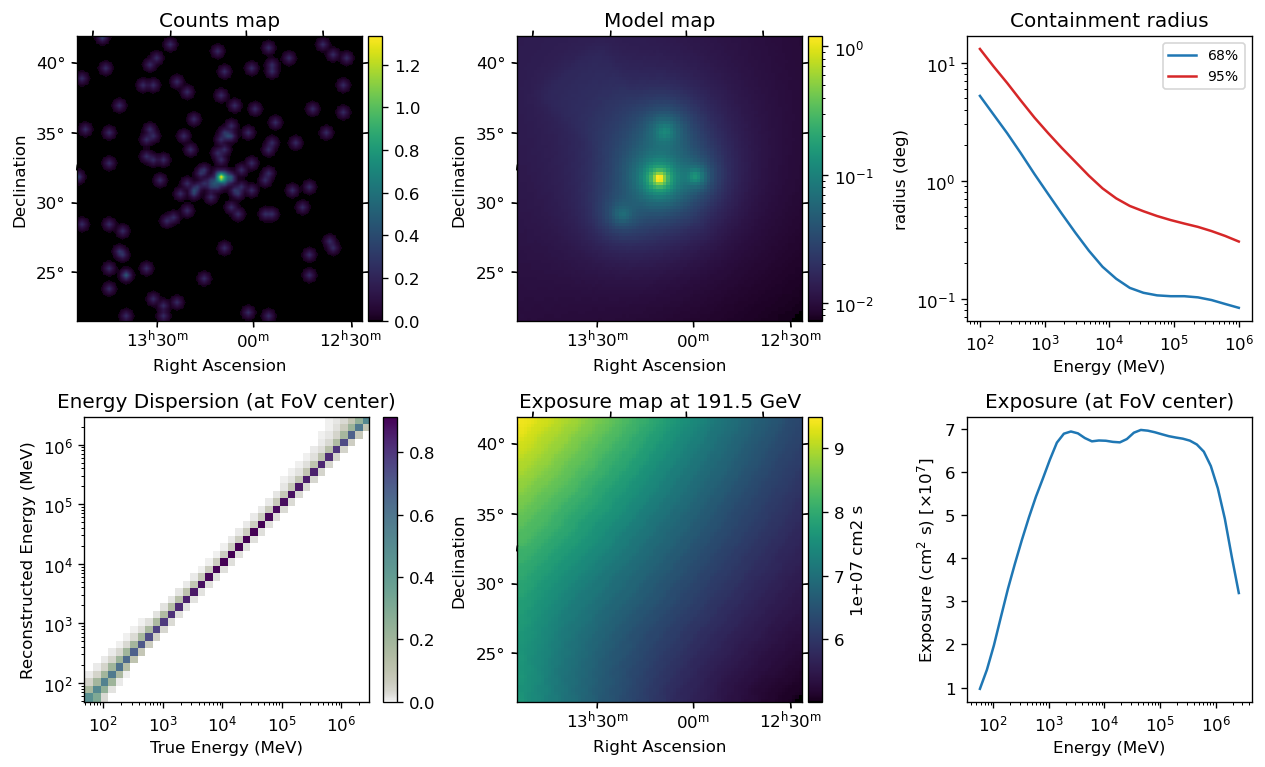

In [20]:
from scipy.ndimage import gaussian_filter
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, LogNorm
from matplotlib import ticker

def make_rgb_transparent(rgba, bg_rgb=(1,1,1)):
    rgb = rgba[0:3]
    alpha = rgba[3]
    return [alpha * c1 + (1 - alpha) * c2
            for (c1, c2) in zip(rgb, bg_rgb)]

countsmapdata = FermiLAT_MapDataset.counts.reduce_over_axes()
npredmapdata  = FermiLAT_MapDataset.npred().reduce_over_axes()

cmapcustom = colormaps.get_cmap('viridis').resampled(256)
cmapcustom.colors *= np.transpose([np.linspace(0,1,len(cmapcustom.colors))]*4)**(1./5)
cmapcustom.colors[:,3] = 1
cmapcustom.set_bad(cmapcustom(npredmapdata.data.min()))

cmapcustom2 = colormaps.get_cmap('viridis_r').resampled(256)
cmapcustom2.colors *= np.transpose([np.linspace(0,1,len(cmapcustom2.colors))]*4)**(1/2.)
cmapcustom2.colors = [make_rgb_transparent(c) for c in cmapcustom2.colors]


fig,axs = plt.subplots(figsize=(11,6.5),ncols=3,nrows=2,dpi=120)

axs[0][0].remove()
axs[0][0] = fig.add_subplot(2, 3, 1, projection=counts_map.geom.wcs)
countsmapdata.smooth(0.2*u.deg).plot(ax=axs[0][0],cmap=cmapcustom,add_cbar=True, 
                                     interpolation='bilinear', 
                                    )
axs[0][0].set_title('Counts map')
axs[0][0].set_box_aspect(1)

axs[0][1].remove()
axs[0][1] = fig.add_subplot(2, 3, 2, projection=FermiLAT_MapDataset.npred().geom.wcs)
npredmapdata.plot(ax=axs[0][1],cmap=cmapcustom,add_cbar=True, 
                  norm=LogNorm(vmin=npredmapdata.data.min(), vmax=npredmapdata.data.max()))
axs[0][1].set_title('Model map')
axs[0][1].set_box_aspect(1)

edispmap = axs[1][0].pcolormesh(
    FermiLAT_MapDataset.edisp.edisp_map.geom.axes['energy_true'].center.value,
    FermiLAT_MapDataset.edisp.edisp_map.geom.axes['energy'].center.value,
    FermiLAT_MapDataset.edisp.edisp_map.data[:,:,0,0],
    cmap=cmapcustom2,
)

axs[1][0].set_xscale('log')
axs[1][0].set_yscale('log')
axs[1][0].set_title('Energy Dispersion (at FoV center)')
axs[1][0].set_xlabel('True Energy (MeV)')
axs[1][0].set_ylabel('Reconstructed Energy (MeV)')
axs[1][0].set_box_aspect(1)


axs[1][1].remove()
axs[1][1] = fig.add_subplot(2, 3, 5, projection=FermiLAT_MapDataset.exposure.geom.wcs)
expmapdata = FermiLAT_MapDataset.exposure.get_image_by_idx([28]).to_unit('10^7 cm2 s') 
energyexpmap = FermiLAT_MapDataset.exposure.geom.axes['energy_true'].center[28]
expmapdata.smooth(0.2*u.deg).plot(ax=axs[1][1],cmap=cmapcustom,add_cbar=True)
axs[1][1].set_title(f'Exposure map at {energyexpmap.to("GeV"):.1f}')
axs[1][1].set_box_aspect(1)

cen_x,cen_y = np.asarray(FermiLAT_MapDataset.exposure.data.shape[1:],dtype=int)/2

axs[1][2].plot(
    FermiLAT_MapDataset.exposure.geom.axes['energy_true'].center,
    FermiLAT_MapDataset.exposure.data[:,int(cen_x),int(cen_y)] *1e-7,
)

axs[1][2].set_title('Exposure (at FoV center)')
axs[1][2].set_xscale('log')
axs[1][2].set_xlabel('Energy (MeV)')
axs[1][2].set_ylabel('Exposure (cm$^2$ s) [$\\times 10^7$]')
axs[1][2].set_box_aspect(1)

earray = np.logspace(-1,3,20)*1E3*u.MeV
axs[0][2].plot(
    earray,
    FermiLAT_MapDataset.psf.containment_radius(fraction=0.68,energy_true=earray),
    label='$68\%$',
    color='C0',
)
axs[0][2].plot(
    earray,
    FermiLAT_MapDataset.psf.containment_radius(fraction=0.95,energy_true=earray),
    label='$95\%$',
    color='C3',
)
axs[0][2].legend(fontsize='small')
axs[0][2].set_title('Containment radius')
axs[0][2].set_xscale('log')
axs[0][2].set_yscale('log')
axs[0][2].set_xlabel('Energy (MeV)')
axs[0][2].set_ylabel('radius (deg)')
axs[0][2].set_box_aspect(1)

plt.colorbar(edispmap,ax=axs[1][0],fraction=0.046, pad=0.04)
x1, y1, w1, h1 = axs[0][2].get_position().bounds
x2, y2, w2, h2 = axs[0][0].get_position().bounds
axs[0][2].set_position([x1, y1, w2, h2])

x1, y1, w1, h1 = axs[1][2].get_position().bounds
x2, y2, w2, h2 = axs[1][1].get_position().bounds
axs[1][2].set_position([x1, y1, w2, h2])

plt.tight_layout(w_pad=0)
!mkdir -p {basedir}/Figures/MJD60373/Fermi-LAT/
fig.savefig(f'{basedir}/Figures/MJD60373/Fermi-LAT/Fermi_IRFs.pdf')
